# Adversarial training for computer vision models

<a href="https://colab.research.google.com/drive/1C6MIY9xTn6N8Czi5yuo5ATw5p2s0uSnK" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

Adversarial machine learning is a specialized area within machine learning dedicated to creating algorithms and techniques capable of resisting and effectively responding to adversarial attacks. This field aims to enhance the robustness of models by understanding potential vulnerabilities and developing strategies to mitigate risks posed by malicious inputs and adversarial intent.

In this notebook, we will create an adversarial dataset to train and test the robustness of two different models. To create our adversarial dataset, we will use the **Fast Gradient Sign Method** ([FGSM](https://arxiv.org/abs/1412.6572)) and the `CIFAR-10` dataset. If you do not want to [train this model](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Adversarial/adversarial_training_cv.ipynb), remember that all our trained models are in the Hub, and you can download them directly. 🤗

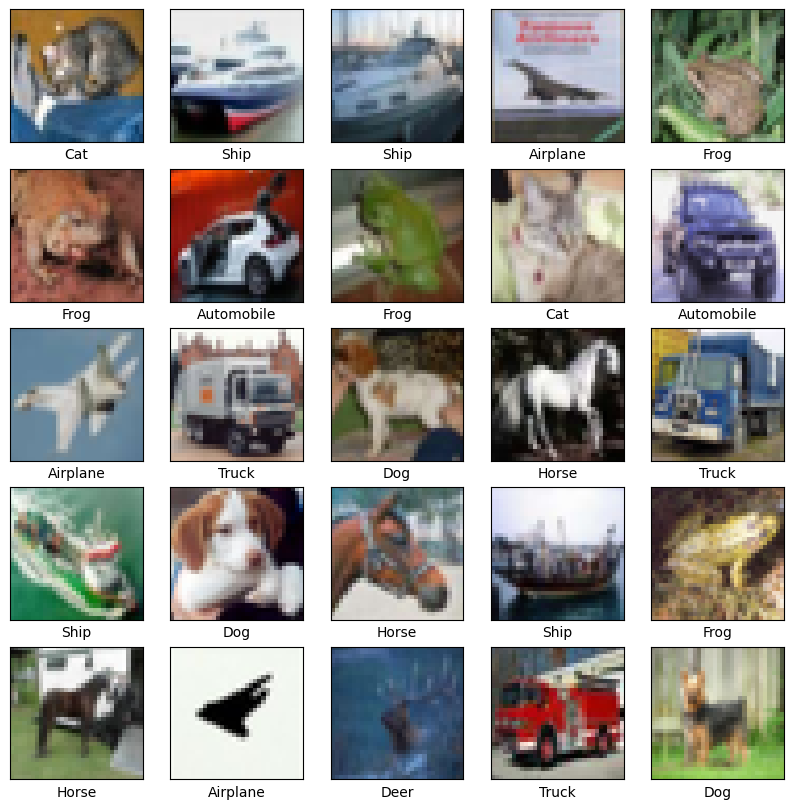

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [9]:
!pip install huggingface_hub["tensorflow"] -q
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from huggingface_hub import from_pretrained_keras

# Download the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i][0]])

plt.show()

# Load the model from the Hub
model = from_pretrained_keras("AiresPucrs/Cifar-CNN")
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
    )
x_train = x_train.astype('float32')
x_train = x_train / 255.
y_train = tf.keras.utils.to_categorical(y_train, 10)
x_test = x_test.astype('float32')
x_test = x_test / 255.
y_test = tf.keras.utils.to_categorical(y_test, 10)
test_loss_score, test_acc_score = model.evaluate(x_test, y_test, verbose=0)
model.summary()
print(f'Loss: {round(test_loss_score, 2)}.')
print(f'Accuracy: {round(test_acc_score * 100, 2)} %.')

Now, let us write a simple function to return labels, predictions, and images.

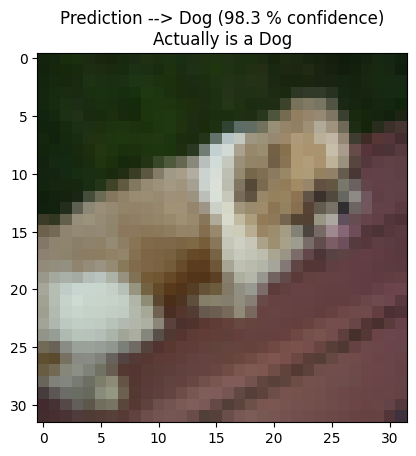

In [5]:
def predict_image(x_test, y_test, sample):
    img_tensor = np.expand_dims(x_test[sample], axis=0)
    pred = [round(num, 3) for num in list(model.predict(img_tensor, verbose=0)[0])]
    plt.figure()
    plt.imshow(x_test[sample])
    plt.title(
        f'Prediction --> {class_names[np.array(pred).argmax()]} ({round(max(pred) * 100, 2)} % confidence)\nActually is a {class_names[y_test[sample].argmax()]}')
    return plt.show()

sample = np.random.randint(0, 9999)
predict_image(x_test, y_test, sample)

Now that we have chosen a sample, we will use the [`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) class to create a loss function. We will also record the class index of this specific sample.

We will use this loss function (rather than serving as a supervision signal for updating the parameters of a neural network), in combination with the class [`tf.GradientTape()`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to create an image (perturbation) that generates the largest possible loss (here we are moving the gradient in the direction in which the loss increases, i.e., gradient ascent) to a specific class.

And that is what the **[Fast Sign Gradient Method](https://arxiv.org/abs/1412.6572)** is all about. In essence, FGSM is to add the noise (not random noise) whose direction is the same as the gradient of the cost function concerning the data.

All this will be encapsulated by a function called `create_adversarial_pattern`.

1/1 [==============================] - 0s 23ms/step


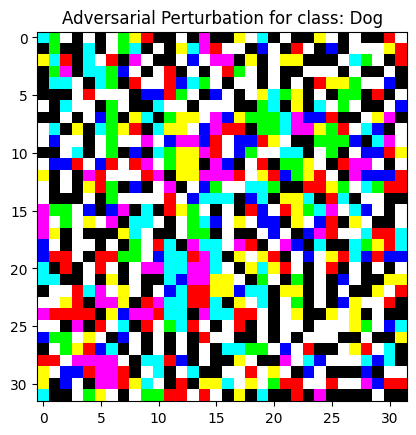

In [7]:
img_tensor = np.expand_dims(x_test[sample], axis=0)
image_probs = model.predict(img_tensor)
class_index = np.argmax(image_probs[0])

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    """
    Computes the adversarial perturbation of an input image using the
    given model and loss function.

    Parameters:
        input_image (tf.Tensor): The input image for which to
            compute the adversarial perturbation.
        input_label (tf.Tensor): The true label of the input image.

    Returns:
        tf.Tensor: The signed gradient of the loss with respect to
        the input image, which represents the direction in which
        the input image should be perturbed in order to increase the loss.
    """
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

label = tf.one_hot(class_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(
    tf.convert_to_tensor(img_tensor, dtype=tf.float32), label)
adversarial_perturbation = (perturbations[0] * 0.5 + 0.5).numpy()
plt.figure()
plt.imshow(adversarial_perturbation)
plt.title(f'Adversarial Perturbation for class: {class_names[class_index]}')
plt.show()

Now, we combine our perturbation with the original image to generate a misclassification. For this explanation, we will only use an  $\epsilon$ of 0.01 since we are interested in developing " imperceptible " attacks on the human observer. Since CIFAR 10 images are low resolution, even a tiny $\epsilon$ can be perceived by the careful eye.

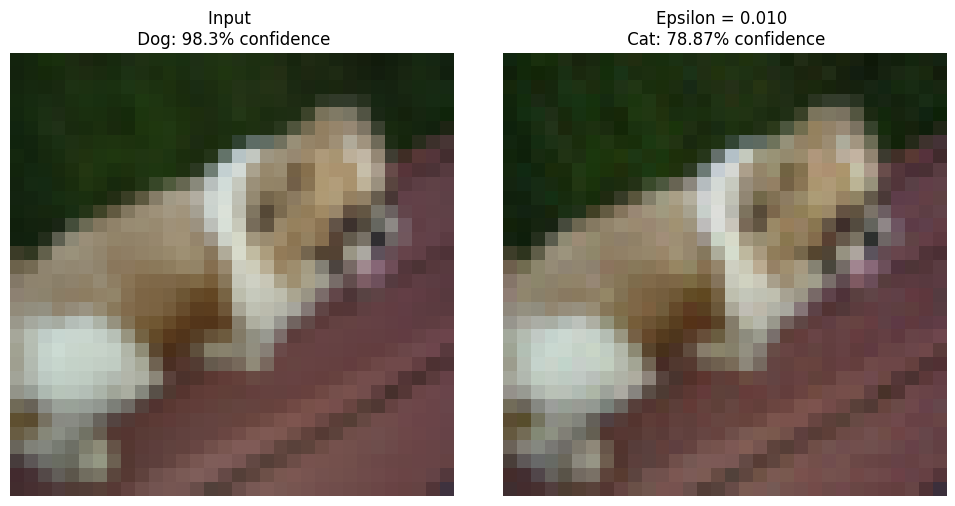

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def display_images(img_tensors, descriptions):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, (img_tensor, description) in enumerate(zip(img_tensors, descriptions)):
        # Model prediction
        image_probs = model.predict(tf.convert_to_tensor(img_tensor, dtype=tf.float32), verbose=0)
        class_confidence = image_probs.max()
        class_index = np.argmax(image_probs[0])

        axes[i].imshow(img_tensor[0])
        axes[i].set_title(f'{description} \n {class_names[class_index]}: {round(class_confidence * 100, 2)}% confidence')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

epsilons = [0, 0.01]
descriptions = ['Input' if eps == 0 else f'Epsilon = {eps:.3f}' for eps in epsilons]

adv_images = [tf.clip_by_value(img_tensor + eps * perturbations, -1, 1) for eps in epsilons]
display_images(adv_images, descriptions)


As you can see, an $\epsilon$ of $0.01$ is enough to fool this model by a significant margin.

In this notebook, we will use a straightforward strategy for creating our adversarial dataset. We will convert ~40% of our original dataset (randomly picked) into adversarial examples and then add those examples to the original dataset, thus creating an adversarial training dataset. This can take considerable time, so skip to the next cell if you want to skip this part and directly download the dataset created for this example.

In [ ]:
from tqdm import tqdm

# Initialize loss and epsilon
loss_object = tf.keras.losses.CategoricalCrossentropy()
eps = 0.01
adversarial_x = []
adversarial_y = []

# Concatenate the training and test datasets
X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

# Loop through the dataset with a progress bar
for i in tqdm(range(len(X)), desc="Generating Adversarial Samples"):

    # Use ~40% of the dataset to create adversarial samples
    if np.random.uniform(0, 1) >= 0.6:

        # Get info on the sample
        img_tensor = np.expand_dims(X[i], axis=0)
        image_probs = model.predict(img_tensor, verbose=0)
        class_index = np.argmax(image_probs[0])

        # Target the specific label
        label = tf.one_hot(class_index, image_probs.shape[-1])
        label = tf.reshape(label, (1, image_probs.shape[-1]))

        # Create perturbation
        perturbations = create_adversarial_pattern(
            tf.convert_to_tensor(img_tensor, dtype=tf.float32), label)
        adversarial_perturbation = (perturbations[0] * 0.5 + 0.5).numpy()

        # Create adversarial sample
        adversarial_sample = tf.clip_by_value(img_tensor + eps * perturbations, -1, 1)

        # Append to adversarial dataset
        adversarial_x.append(adversarial_sample[0].numpy())
        adversarial_y.append(Y[i])

# Convert lists to numpy arrays
adversarial_x = np.array(adversarial_x).astype('float32')
adversarial_y = np.array(adversarial_y)

# Save adversarial data to a file
with open('adversarial_data_CIFAR_10.npy', 'wb') as f:
    np.save(f, adversarial_x)
    np.save(f, adversarial_y)

Now, we will divide our adversarial dataset into two parts: one to train a new model and one to test the robustness of both models.

In [14]:
import numpy as np
from huggingface_hub import hf_hub_download
from sklearn.model_selection import train_test_split

# Download the adversarial dataset from the Hub
file_path = hf_hub_download(
    repo_id="AiresPucrs/Cifar-CNN-with-adversarial-training",
    filename="adversarial-data-CIFAR-10.npy",
    local_dir="./",
    repo_type="model"
)

# Load the adversarial data from the file
with open(file_path, 'rb') as fp:
    adversarial_x = np.load(fp)
    adversarial_y = np.load(fp)

# Split adversarial data into training and test sets
adversarial_x_training = adversarial_x[:20000]
adversarial_x_test = adversarial_x[20000:]

adversarial_y_training = adversarial_y[:20000]
adversarial_y_test = adversarial_y[20000:]

# Concatenate adversarial training data with the original dataset
X = np.concatenate((X, adversarial_x_training), axis=0)
Y = np.concatenate((Y, adversarial_y_training), axis=0)

# Split the combined dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42
)


adversarial-data-CIFAR-10.npy:   0%|          | 0.00/297M [00:00<?, ?B/s]

We will now train the "same model" ([same architecture and hyperparemeters]()) with this adversarial dataset.

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',
          activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

model.summary()

callbacks = [tf.keras.callbacks.ModelCheckpoint("Cifar-CNN-with-adversarial-training.keras",
                                                save_best_only=True),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            patience=3,
                                            verbose=1,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True)]

model.fit(x_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=80,
    verbose=1,
    callbacks=callbacks)

test_loss_score, test_acc_score = model.evaluate(x_test, y_test)

print(f'Final Loss: {round(test_loss_score, 2)}.')
print(f'Final Performance: {round(test_acc_score * 100, 2)} %.')

For comparison reasons, we will define our models' robustness score as their accuracy against the test portion of our adversarial dataset.

In [20]:
import tensorflow as tf
from huggingface_hub import from_pretrained_keras

def evaluate_model(repo_id, test_data, test_labels, description):
    # Load and compile the model
    model = from_pretrained_keras(repo_id)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy']
    )

    # Evaluate the model
    print(f'\n# Model Evaluation: {description}\n\n{"-" * 50}\n')
    _, test_acc_score = model.evaluate(test_data, test_labels, verbose=0)
    print(f'- Robustness Score: {round(test_acc_score * 100, 2)} %.\n')

# Evaluate the base model
evaluate_model(
    repo_id="AiresPucrs/Cifar-CNN",
    test_data=adversarial_x_test,
    test_labels=adversarial_y_test,
    description="Base Model Against Adversaries"
)

# Evaluate the adversarially trained model
evaluate_model(
    repo_id="AiresPucrs/Cifar-CNN-with-adversarial-training",
    test_data=adversarial_x_test,
    test_labels=adversarial_y_test,
    description="Adversarially Trained Model Against Adversaries"
)


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]


# Model Evaluation: Base Model Against Adversaries

--------------------------------------------------

- Robustness Score: 34.19 %.



Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]


# Model Evaluation: Adversarially Trained Model Against Adversaries

--------------------------------------------------

- Robustness Score: 90.43 %.



As we can see, the model trained with a combination of normal and perturbed data receives a robustness score of around 90%! Adversarial training is a technique that can significantly enhance the robustness of AI models against various adversarial attacks. AI developers can create models that better generalize against attacks by incorporating adversarial examples into training. 🙃

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).